<div class="alert alert-block alert-info"> <b>NOTE</b> 

<div>
    This is a duplicate of notebook <b>04_prediction.ipynb </b>
    in this notebook we load the normalization weights to realize prediction with the new models.
</div>
</div>

In [1]:
import os
import joblib
import pickle
import random
import pandas as pd
import matplotlib.pyplot as plt
from auxiliary_functions import load_joblib
from evaluation_metrics import similarity, similarity_block, distance_pred, performance, time_window_perform, oscillation_red
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# For testing data

In [2]:
#Load the model and data
path_to_read1 = '/Users/luisescobar/Documents/Thesis/Models/ADASYN/point_six'
path_to_read2 = '/Users/luisescobar/Documents/Thesis/DataSets/Dictionary/03_01_Train_Val_Test'
path_to_read3 = '/Users/luisescobar/Documents/Thesis/Models'
filename_model = 'lightgbm_model_test.pkl'
filename_clot = 'blocking_20.pkl'
filename_noclot = 'no_blocking_20.pkl'
filename_scaler = 'scaler.pkl'

#model_loaded = load_joblib(path_to_read1, filename_model)
model_loaded = load_joblib(path_to_read1, filename_model)
scaler_loaded = load_joblib(path_to_read3, filename_scaler)
clot_dict = load_joblib(path_to_read2, filename_clot)
no_clot_dict = load_joblib(path_to_read2, filename_noclot)


In [3]:
#Choose arbitrary a dataset from the blocking class
clot_dict.keys()

dict_keys(['df_1', 'df_923', 'df_680-df_681-concat', 'df_654', 'df_311', 'df_344-df_345-df_346-concat', 'df_902', 'df_486', 'df_513', 'df_62', 'df_653', 'df_783', 'df_790', 'df_247', 'df_190', 'df_751', 'df_764', 'df_859', 'df_115'])

In [4]:
lag = 10
random.seed(42)
loaded_dict = {**clot_dict, **no_clot_dict}

items = list(loaded_dict.items())
random.shuffle(items)
loaded_dict = dict(items)

#Create a single DataFrame ready to train
dataframes_list = list(loaded_dict.values())

# Concatenate all DataFrames vertically. Each Data Frame starts with zero so a 
combined_df = pd.concat(dataframes_list, ignore_index=False)
#combined_df = pd.concat(dataframes_list, ignore_index=True)
combined_df = combined_df.reset_index(drop=True)

# Create lagged features for each column except the target column
for column in combined_df.columns:
    if column != 'Clotting_2':  # Skip the target column
        combined_df[f'{column}_lag_{lag}'] = combined_df[column].shift(lag)

# Remove rows with NaN values (due to shifting)
df_lagged = combined_df.dropna()
df_lagged = df_lagged.reset_index(drop=True)

# Prepare features (X) and target (y)
# Drop original columns and only use lagged features
lagged_columns = [col for col in df_lagged.columns if 'lag_' in col]
X = df_lagged[lagged_columns]
X = scaler_loaded.transform(X)
y_true = df_lagged['Clotting_2']  # Target variable

In [5]:
use_threshold = True

if use_threshold == False:
    # Make predictions using the lag feature matrix
    y_pred = model_loaded.predict(X)
    
else:
    # Get predicted probabilities
    probs = model_loaded.predict_proba(X)
    
    # Define a custom threshold, e.g., 0.7
    threshold = 0.7
    
    # Assign Class 1 if the probability for Class 1 is greater than or equal to the threshold, else Class 0
    y_pred = (probs[:, 1] >= threshold).astype(int)

In [6]:
# Performance of the predictions

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Classification Report
class_report = classification_report(y_true, y_pred)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

Confusion Matrix:
[[301711   6422]
 [   811    871]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    308133
           1       0.12      0.52      0.19      1682

    accuracy                           0.98    309815
   macro avg       0.56      0.75      0.59    309815
weighted avg       0.99      0.98      0.98    309815



# For validation data
To recover information from training / validation set 

In [7]:
# For validation
path_to_read = '/Users/luisescobar/Documents/Thesis/DataSets/Dictionary/03_01_Train_Val_Test'
path_to_save = '/Users/luisescobar/Documents/Thesis/Models'

file_name_block = 'blocking_80.pkl'
file_name_no_block = 'no_blocking_80.pkl'

'''name_to_read_block = f'{path_to_read}/{file_name_block}'
name_to_read_no_block = f'{path_to_read}/{file_name_no_block}'

with open(name_to_read_block, 'rb') as file:
    dict_block = pickle.load(file)

with open(name_to_read_no_block, 'rb') as file:
    dict_no_block = pickle.load(file)
'''

dict_block = load_joblib(path_to_read, file_name_block)
dict_no_block = load_joblib(path_to_read, file_name_no_block)


random.seed(42)
loaded_dict = {**dict_block, **dict_no_block}

items = list(loaded_dict.items())
random.shuffle(items)
loaded_dict = dict(items)

#Create a single DataFrame ready to train
dataframes_list = list(loaded_dict.values())

# Concatenate all DataFrames vertically. Each Data Frame starts with zero so a 
combined_df = pd.concat(dataframes_list, ignore_index=False)
#combined_df = pd.concat(dataframes_list, ignore_index=True)
combined_df = combined_df.reset_index(drop=True)

# Create lagged features for each column except the target column
for column in combined_df.columns:
    if column != 'Clotting_2':  # Skip the target column
        combined_df[f'{column}_lag_{lag}'] = combined_df[column].shift(lag)

# Remove rows with NaN values (due to shifting)
df_lagged = combined_df.dropna()
df_lagged = df_lagged.reset_index(drop=True)
# Prepare features (X) and target (y)
# Drop original columns and only use lagged features
lagged_columns = [col for col in df_lagged.columns if 'lag_' in col]
X = df_lagged[lagged_columns]
X = scaler_loaded.transform(X)
y = df_lagged['Clotting_2']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=True) 

y_pred = model_loaded.predict(X_test)

# Performance of the predictions

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification Report
class_report = classification_report(y_test, y_pred)

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")


 

Confusion Matrix:
[[126657    541]
 [     2    474]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127198
           1       0.47      1.00      0.64       476

    accuracy                           1.00    127674
   macro avg       0.73      1.00      0.82    127674
weighted avg       1.00      1.00      1.00    127674



# For one sample

In [7]:
clot_dict.keys()

dict_keys(['df_1', 'df_923', 'df_680-df_681-concat', 'df_654', 'df_311', 'df_344-df_345-df_346-concat', 'df_902', 'df_486', 'df_513', 'df_62', 'df_653', 'df_783', 'df_790', 'df_247', 'df_190', 'df_751', 'df_764', 'df_859', 'df_115'])

In [12]:
df = clot_dict['df_1']
use_threshold = False


# Create lagged features for each column except the target column
for column in df.columns:
    if column != 'Clotting_2':  # Skip the target column
        df[f'{column}_lag_{lag}'] = df[column].shift(lag)

# Remove rows with NaN values (due to shifting)
df_lagged = df.dropna()
df_lagged = df_lagged.reset_index(drop=True)

# Prepare features (X) and target (y)
# Drop original columns and only use lagged features
lagged_columns = [col for col in df_lagged.columns if 'lag_' in col]
X = df_lagged[lagged_columns]
X = scaler_loaded.transform(X)
y_true = df_lagged['Clotting_2'] 



if use_threshold == False:
    # Make predictions using the lag feature matrix
    y_pred = model_loaded.predict(X)
    
else:
    # Get predicted probabilities
    probs = model_loaded.predict_proba(X)
    
    # Define a custom threshold, e.g., 0.7
    threshold = 0.7
    
    # Assign Class 1 if the probability for Class 1 is greater than or equal to the threshold, else Class 0
    y_pred = (probs[:, 1] >= threshold).astype(int)




In [13]:
# Regularization on oscillations (on test)
y_pred_reg = oscillation_red(y_pred, 0.1, 20)


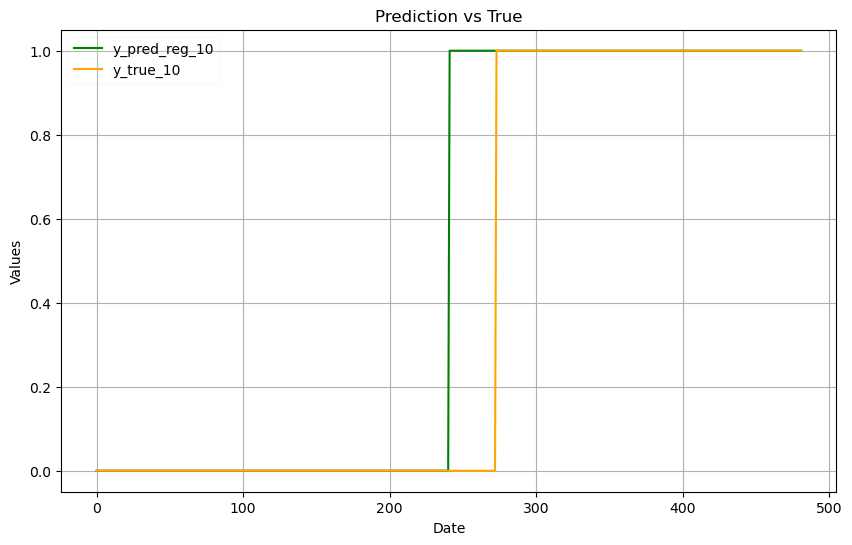

In [15]:
# Compare y_true with y_pred to see in which points we have the wrong classifications
# Plotting the two columns
plt.figure(figsize=(10, 6))
plt.plot(y_pred_reg, label='y_pred_reg_10', color = 'green')
#plt.plot(y_pred, label='y_pred_10', color = 'blue')
plt.plot(y_true, label='y_true_10', color= 'orange')


plt.title('Prediction vs True')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend(loc = 'upper left', framealpha=0.1)
plt.grid(True)
plt.show()

In [16]:
similar = similarity_block(y_pred_reg, y_true)
distance = distance_pred(y_pred_reg, y_true)
perform = performance(similar, distance, 20)
print(similar)
print(distance)
print(perform)

0.10444444444444445
-403
-7.115733998973682e-90


In [17]:
result =  time_window_perform(y_pred_reg, y_true, 10, True)

Confussion matrix:
+-------------------+-----+-----+
|   True\Prediction |   0 |   1 |
+===================+=====+=====+
|                 0 |   0 | 399 |
+-------------------+-----+-----+
|                 1 |   0 |  51 |
+-------------------+-----+-----+

Classification Report:
+-----+-------------+----------+
|     |   precision |   recall |
+=====+=============+==========+
|   0 |    0        |        0 |
+-----+-------------+----------+
|   1 |    0.113333 |        1 |
+-----+-------------+----------+
